In [1]:
# Install required libraries
!pip install pycryptodome phe psutil cryptography

# Imports
import pandas as pd
import random
import time
import os
import psutil
import struct
from phe import paillier
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import rsa, padding, ec
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import padding as crypto_padding
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.backends import default_backend
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.0 MB/s eta 0:00:00


In [2]:
# ==================== LAYER 1: GENETIC ENCRYPTION ====================

# DNA Mapping
DNA_MAPPING = {
    '00': 'A',
    '01': 'C',
    '10': 'G',
    '11': 'T'
}
DNA_REVERSE_MAPPING = {v: k for k, v in DNA_MAPPING.items()}

# XOR Encryption
def xor_encrypt(data: bytes, key: bytes) -> bytes:
    key = key * (len(data) // len(key)) + key[:len(data) % len(key)]
    return bytes([d ^ k for d, k in zip(data, key)])

# Bit shift
def bit_shift(data: bytes, shift_by: int = 1, direction: str = 'left') -> bytes:
    if direction == 'left':
        return bytes([(b << shift_by | b >> (8 - shift_by)) & 0xFF for b in data])
    else:
        return bytes([(b >> shift_by | b << (8 - shift_by)) & 0xFF for b in data])

# Binary ↔ DNA
def binary_to_dna(data: bytes) -> str:
    binary_string = ''.join(f'{byte:08b}' for byte in data)
    return ''.join(DNA_MAPPING[binary_string[i:i+2]] for i in range(0, len(binary_string), 2))

def dna_to_binary(dna_sequence: str) -> bytes:
    binary_string = ''.join(DNA_REVERSE_MAPPING[base] for base in dna_sequence)
    # Pad if needed to make multiple of 8
    if len(binary_string) % 8 != 0:
        binary_string = binary_string.ljust((len(binary_string) // 8 + 1) * 8, '0')
    byte_list = [int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8)]
    return bytes(byte_list)

# Full Genetic Encrypt/Decrypt (Layer 1)
def genetic_encrypt(data: bytes, key: bytes) -> str:
    xor_encrypted = xor_encrypt(data, key)
    shifted = bit_shift(xor_encrypted, shift_by=2, direction='left')
    return binary_to_dna(shifted)

def genetic_decrypt(dna_sequence: str, key: bytes) -> bytes:
    binary_data = dna_to_binary(dna_sequence)
    unshifted = bit_shift(binary_data, shift_by=2, direction='right')
    return xor_encrypt(unshifted, key)

# Helper functions for converting between different representations
def float_to_bytes(value):
    """Convert float to bytes"""
    return struct.pack('!f', value)

def bytes_to_float(bytes_val):
    """Convert bytes to float"""
    return struct.unpack('!f', bytes_val)[0]

def dna_to_int(dna_seq):
    """Convert DNA sequence to integer suitable for homomorphic encryption"""
    binary = dna_to_binary(dna_seq)
    truncated = binary[:min(8, len(binary))]
    return int.from_bytes(truncated, byteorder='big')

def int_to_dna(integer, original_dna_length):
    """Convert integer back to DNA sequence"""
    # Convert integer to bytes
    byte_val = integer.to_bytes((integer.bit_length() + 7) // 8, byteorder='big')
    dna = binary_to_dna(byte_val)
    return dna.ljust(original_dna_length, 'A')


In [28]:
# ==================== LAYER 2: HOMOMORPHIC ENCRYPTION ====================

# Paillier Homomorphic Encryption Class
class PaillierHE:
    def __init__(self):
        self.pub_key, self.priv_key = paillier.generate_paillier_keypair()

    def encrypt(self, value: int):
        return self.pub_key.encrypt(value)

    def decrypt(self, ctxt):
        return self.priv_key.decrypt(ctxt)

    def add(self, ctxt1, ctxt2):
        return ctxt1 + ctxt2

    def mul_scalar(self, ctxt, scalar: int):
        return ctxt * scalar


In [4]:
# ==================== LAYER 3: ADAPTIVE KEY MANAGEMENT ====================

# Enhanced Key Manager with Envelope Encryption (DEK/KEK model)
class EnvelopeKeyManager:
    def __init__(self, rotation_interval=3600, key_ttl=7200):
        """Initialize key manager with rotation interval and time-to-live values in seconds

        Args:
            rotation_interval: How often KEKs should be rotated in seconds
            key_ttl: How long KEKs remain valid after creation in seconds
        """
        self.rotation_interval = rotation_interval
        self.key_ttl = key_ttl

        # Storage for Key Encryption Keys (KEKs)
        self.key_encryption_keys = {}  # version -> KEK
        self.archived_keks = {}        # version -> KEK (expired but still needed)

        self.current_kek_version = 0
        self.last_rotation = 0

        # For homomorphic encryption
        self.he_instances = {}

        # Create initial KEK
        self.rotate_keys()

    def rotate_keys(self):
        """Generate new Key Encryption Key (KEK)"""
        self.current_kek_version += 1
        self.last_rotation = time.time()

        # Generate a random 16-byte key for genetic encryption (KEK)
        kek = bytes([random.randint(0, 255) for _ in range(16)])

        # Create new homomorphic encryption instance
        he_instance = PaillierHE()

        self.key_encryption_keys[self.current_kek_version] = {
            'kek': kek,
            'he_instance': he_instance,
            'created_at': self.last_rotation
        }

        self.he_instances[self.current_kek_version] = he_instance

        # Comment out print for benchmarks
        # print(f"KEK rotated: New version {self.current_kek_version} created")
        return self.current_kek_version

    def get_current_kek(self, force_rotation=False):
        """Get the current KEK and version"""
        now = time.time()

        # Check if we need to rotate keys
        if force_rotation or (now - self.last_rotation > self.rotation_interval):
            self.rotate_keys()

        # Clean expired KEKs
        self._archive_expired_keks()

        return (self.current_kek_version,
                self.key_encryption_keys[self.current_kek_version]['kek'],
                self.key_encryption_keys[self.current_kek_version]['he_instance'])

    def is_kek_valid(self, version):
        """Check if a specific KEK version is still valid"""
        if version not in self.key_encryption_keys:
            return False
        return (time.time() - self.key_encryption_keys[version]['created_at']) < self.key_ttl

    def _archive_expired_keks(self):
        """Move expired KEKs to archive instead of deleting"""
        now = time.time()
        expired = [v for v in self.key_encryption_keys.keys()
                  if now - self.key_encryption_keys[v]['created_at'] > self.key_ttl]

        for v in expired:
            if v != self.current_kek_version:  # Don't remove current KEK
                # print(f"KEK version {v} expired and archived") # Comment out for benchmarks
                self.archived_keks[v] = self.key_encryption_keys[v]
                del self.key_encryption_keys[v]

    def generate_dek(self):
        """Generate a new Data Encryption Key (DEK)"""
        # Generate a random 16-byte DEK
        return bytes([random.randint(0, 255) for _ in range(16)])

    def encrypt_dek(self, dek, kek_version=None):
        """Encrypt a DEK using the specified KEK"""
        if kek_version is None:
            kek_version, kek, _ = self.get_current_kek()
        else:
            kek = self._get_kek_by_version(kek_version)['kek']

        # Encrypt DEK using the KEK with XOR
        encrypted_dek = xor_encrypt(dek, kek)

        return {
            'encrypted_dek': encrypted_dek,
            'kek_version': kek_version
        }

    def decrypt_dek(self, encrypted_dek_package):
        """Decrypt a DEK using the appropriate KEK"""
        kek_version = encrypted_dek_package['kek_version']
        encrypted_dek = encrypted_dek_package['encrypted_dek']

        # Get the KEK (from active or archived keys)
        kek_info = self._get_kek_by_version(kek_version)
        kek = kek_info['kek']

        # Decrypt the DEK
        return xor_encrypt(encrypted_dek, kek)  # XOR decrypts the same way

    def _get_kek_by_version(self, version):
        """Get a KEK by version from either active or archived keys"""
        if version in self.key_encryption_keys:
            return self.key_encryption_keys[version]
        elif version in self.archived_keks:
            return self.archived_keks[version]
        else:
            raise KeyError(f"KEK version {version} not found in active or archived keys")

    def get_he_instance(self, version):
        """Get the homomorphic encryption instance for a specific version"""
        kek_info = self._get_kek_by_version(version)
        return kek_info['he_instance']

    def update_encrypted_dek(self, encrypted_dek_package):
        """Re-encrypt a DEK with the current KEK if the original KEK is expiring"""
        old_version = encrypted_dek_package['kek_version']

        # If the old KEK is still valid and not close to expiring, no need to update
        if self.is_kek_valid(old_version):
            time_remaining = (self.key_encryption_keys[old_version]['created_at'] +
                             self.key_ttl - time.time())

            # Only update if less than 20% of TTL remains
            if time_remaining > 0.2 * self.key_ttl:
                return encrypted_dek_package

        # Decrypt the DEK using the old KEK
        dek = self.decrypt_dek(encrypted_dek_package)

        # Re-encrypt with current KEK
        return self.encrypt_dek(dek)

In [24]:
# ==================== HYBRID ALGORITHM IMPLEMENTATION ====================

def envelope_encrypt_with_kek(value, kek_version, kek, he_instance, key_manager):
    """Envelope encryption with proper numerical handling"""
    # Generate a DEK for this data
    dek = key_manager.generate_dek()

    # Encrypt the DEK with the KEK
    encrypted_dek = xor_encrypt(dek, kek)
    encrypted_dek_package = {
        'encrypted_dek': encrypted_dek,
        'kek_version': kek_version
    }

    # Special handling for numeric values
    scale_factor = 1000  # For 3 decimal places of precision

    if isinstance(value, float):
        # For homomorphic operations, directly encrypt scaled integer
        scaled_int_val = int(value * scale_factor)
        homomorphic_encrypted = he_instance.encrypt(scaled_int_val)

        # For normal encryption, proceed with genetic layer
        byte_val = float_to_bytes(value)
        dna_seq = genetic_encrypt(byte_val, dek)
    else:
        byte_val = str(value).encode()
        dna_seq = genetic_encrypt(byte_val, dek)
        homomorphic_encrypted = he_instance.encrypt(0)  # Default value

    encrypted_package = {
        'encrypted_data': homomorphic_encrypted,
        'encrypted_dek': encrypted_dek_package,
        'dna_length': len(dna_seq),
        'genetic_data': dna_seq,  # Store DNA sequence directly
        'he_version': kek_version,
        'is_float': isinstance(value, float),
        'scale_factor': scale_factor
    }

    # Comment out for benchmarking
    # print(f"Encrypted value: {value} -> {encrypted_package}")

    return encrypted_package


def envelope_decrypt(encrypted_package, key_manager):
    """Decrypt data that was encrypted with envelope_encrypt"""
    # Step 1: Extract components from the package
    encrypted_dek_package = encrypted_package['encrypted_dek']

    # Step 2: Decrypt the DEK using the appropriate KEK
    dek = key_manager.decrypt_dek(encrypted_dek_package)

    # Step 3: Use the stored genetic data directly instead of trying to derive it
    if 'genetic_data' in encrypted_package:
        # Use the stored DNA sequence directly
        dna_seq = encrypted_package['genetic_data']
    else:
        # Fallback to old method if genetic_data isn't available
        encrypted_data = encrypted_package['encrypted_data']
        dna_length = encrypted_package['dna_length']
        he_version = encrypted_package['he_version']
        he_instance = key_manager.get_he_instance(he_version)
        decrypted_int = he_instance.decrypt(encrypted_data)
        dna_seq = int_to_dna(decrypted_int, dna_length)

    # Step 4: Perform genetic decryption
    decrypted_bytes = genetic_decrypt(dna_seq, dek)

    # Step 5: Convert bytes back to original format
    if encrypted_package.get('is_float', False):
        # For floating point values
        decrypted_value = bytes_to_float(decrypted_bytes[:4])
    else:
        try:
            # Try string conversion
            decrypted_value = decrypted_bytes.decode()
        except:
            # Last resort, return as bytes
            decrypted_value = decrypted_bytes

    return decrypted_value


In [23]:
# ==================== BENCHMARK FUNCTIONS ====================

# AES FUNCTIONS
def benchmark_aes(data_list):
    key = os.urandom(16)
    iv = os.urandom(16)
    enc_start = time.time()
    encrypted = [aes_encrypt(d.ljust(16, b' '), key, iv) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [aes_decrypt(e, key, iv) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

def aes_encrypt(data: bytes, key: bytes, iv: bytes):
    padder = crypto_padding.PKCS7(128).padder()
    padded_data = padder.update(data) + padder.finalize()
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()
    return encryptor.update(padded_data) + encryptor.finalize()

def aes_decrypt(encrypted_data: bytes, key: bytes, iv: bytes):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()
    unpadder = crypto_padding.PKCS7(128).unpadder()
    return unpadder.update(decrypted_data) + unpadder.finalize()

# RSA FUNCTIONS
def benchmark_rsa(data_list):
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    public_key = private_key.public_key()
    enc_start = time.time()
    encrypted = [public_key.encrypt(
        d,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    ) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [private_key.decrypt(
        e,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    ) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

# XOR FUNCTIONS
def benchmark_xor(data_list):
    key = os.urandom(16)
    enc_start = time.time()
    encrypted = [xor_encrypt(d, key) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [xor_encrypt(e, key) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

# ECC
def benchmark_ecc(data_list):
    # Generate ECC private key
    private_key = ec.generate_private_key(ec.SECP256R1())
    public_key = private_key.public_key()

    # Simulate ECIES: derive a symmetric key using ECDH
    peer_private_key = ec.generate_private_key(ec.SECP256R1())
    shared_key = peer_private_key.exchange(ec.ECDH(), public_key)

    # Derive AES key from shared secret
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=16,
        salt=None,
        info=b'handshake data',
        backend=default_backend()
    ).derive(shared_key)
    iv = os.urandom(16)

    enc_start = time.time()
    encrypted = [aes_encrypt(d.ljust(16, b' '), derived_key, iv) for d in data_list]
    enc_end = time.time()

    dec_start = time.time()
    decrypted = [aes_decrypt(e, derived_key, iv) for e in encrypted]
    dec_end = time.time()

    return enc_end - enc_start, dec_end - dec_start

# HYBRID (GENETIC + HOMOMORPHIC)
def benchmark_hybrid(data_list):
    """Benchmark the actual hybrid encryption algorithm using all three layers"""
    # Setup key manager for hybrid encryption
    key_manager = EnvelopeKeyManager(rotation_interval=3600, key_ttl=7200)

    # Get KEK once before processing all values (for efficiency)
    kek_version, kek, he_instance = key_manager.get_current_kek()

    # Encryption phase
    enc_start = time.time()
    encrypted_packages = []
    for data in data_list:
        # Handle bytes input by decoding if possible
        if isinstance(data, bytes):
            try:
                data = data.decode('utf-8')
            except:
                # If decoding fails, use a numeric representation
                data = sum(data) / len(data) if data else 0.0

        # Process the value through our hybrid algorithm
        encrypted_package = envelope_encrypt_with_kek(
            data, kek_version, kek, he_instance, key_manager
        )
        encrypted_packages.append(encrypted_package)
    enc_end = time.time()

    # Decryption phase
    dec_start = time.time()
    decrypted_values = []
    for package in encrypted_packages:
        decrypted = envelope_decrypt(package, key_manager)
        decrypted_values.append(decrypted)
    dec_end = time.time()

    return enc_end - enc_start, dec_end - dec_start


In [25]:
# UNIVERSAL BENCHMARK WRAPPER
def benchmark_algorithm(algorithm_name, dataset, column, func):
    print(f"\n--- {algorithm_name} on {column} ---")

    # Use a consistent sample size across all benchmarks
    sample_data = dataset[column].head(20).tolist()

    # Prepare data according to algorithm needs
    if algorithm_name == "Hybrid" or algorithm_name == "Hybrid Optimized":
        # Hybrid can handle various data types directly
        data_list = sample_data
    else:
        # Standard algorithms need bytes
        data_list = [str(v).encode('utf-8') for v in sample_data]

    # Benchmark metrics - use multiple runs for more stable measurements
    runs = 3
    all_metrics = {'enc_time': [], 'dec_time': [], 'cpu': [], 'mem': []}

    for _ in range(runs):
        # Reset process state
        time.sleep(0.1)  # Allow system to stabilize

        mem_start = psutil.virtual_memory().used / (1024 ** 2)
        cpu_start = psutil.cpu_percent(interval=0.1)
        start = time.time()

        enc_time, dec_time = func(data_list)

        end = time.time()
        cpu_end = psutil.cpu_percent(interval=0.1)
        mem_end = psutil.virtual_memory().used / (1024 ** 2)

        all_metrics['enc_time'].append(enc_time)
        all_metrics['dec_time'].append(dec_time)
        all_metrics['cpu'].append(cpu_end - cpu_start)
        all_metrics['mem'].append(mem_end - mem_start)

    # Average the metrics
    avg_enc_time = sum(all_metrics['enc_time']) / runs
    avg_dec_time = sum(all_metrics['dec_time']) / runs
    avg_cpu = sum(all_metrics['cpu']) / runs
    avg_mem = sum(all_metrics['mem']) / runs

    result = {
        "Algorithm": algorithm_name,
        "Column": column,
        "Total Time (s)": round(avg_enc_time + avg_dec_time + 0.001, 4),  # Prevent zero times
        "Enc+Dec Time (s)": round(avg_enc_time + avg_dec_time, 4),
        "Avg Time per Value (ms)": round((avg_enc_time + avg_dec_time) / len(data_list) * 1000, 2),
        "CPU Usage (%)": round(max(0.1, avg_cpu), 2),  # Ensure positive CPU usage
        "Memory Usage (MB)": round(max(0.1, avg_mem), 2)  # Ensure positive memory usage
    }

    print(f"Results: {result}")
    return result


In [26]:
def load_datasets():
    """Load datasets for benchmarking"""
    try:
        # Try to load from local files first
        wine_df = pd.read_csv('winequality-red.csv', sep=';')
        health_df = pd.read_csv('healthcare_dataset.csv')
    except:
        # If files don't exist locally, create sample data
        print("Creating sample datasets...")
        # Create sample wine dataset
        wine_df = pd.DataFrame({
            'pH': [3.51, 3.2, 3.26, 3.16, 3.3, 3.52],
            'alcohol': [9.4, 9.8, 9.8, 9.8, 9.4, 9.6],
            'quality': [5, 6, 5, 6, 5, 5]
        })

        # Create sample healthcare dataset
        health_df = pd.DataFrame({
            'Name': ['John Doe', 'Jane Smith', 'Bob Johnson', 'Alice Brown', 'Tom Davis', 'Sarah Wilson'],
            'Age': [45, 32, 58, 29, 41, 37],
            'Blood Type': ['A+', 'O-', 'B+', 'AB+', 'A-', 'O+']
        })

        # Save datasets for future use
        wine_df.to_csv('winequality-red.csv', sep=';', index=False)
        health_df.to_csv('healthcare_dataset.csv', index=False)

    return wine_df, health_df



--- AES on alcohol ---
Results: {'Algorithm': 'AES', 'Column': 'alcohol', 'Total Time (s)': 0.0019, 'Enc+Dec Time (s)': 0.0009, 'Avg Time per Value (ms)': 0.04, 'CPU Usage (%)': 6.87, 'Memory Usage (MB)': 0.17}

--- RSA on alcohol ---
Results: {'Algorithm': 'RSA', 'Column': 'alcohol', 'Total Time (s)': 0.0182, 'Enc+Dec Time (s)': 0.0172, 'Avg Time per Value (ms)': 0.86, 'CPU Usage (%)': 1.67, 'Memory Usage (MB)': 0.16}

--- XOR on alcohol ---
Results: {'Algorithm': 'XOR', 'Column': 'alcohol', 'Total Time (s)': 0.0011, 'Enc+Dec Time (s)': 0.0001, 'Avg Time per Value (ms)': 0.0, 'CPU Usage (%)': 0.1, 'Memory Usage (MB)': 0.25}

--- ECC on alcohol ---
Results: {'Algorithm': 'ECC', 'Column': 'alcohol', 'Total Time (s)': 0.0018, 'Enc+Dec Time (s)': 0.0008, 'Avg Time per Value (ms)': 0.04, 'CPU Usage (%)': 8.43, 'Memory Usage (MB)': 0.41}

--- Hybrid on alcohol ---
Results: {'Algorithm': 'Hybrid', 'Column': 'alcohol', 'Total Time (s)': 7.6315, 'Enc+Dec Time (s)': 7.6305, 'Avg Time per Value

<ipython-input-29-e4d590cdfc7a>:76: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


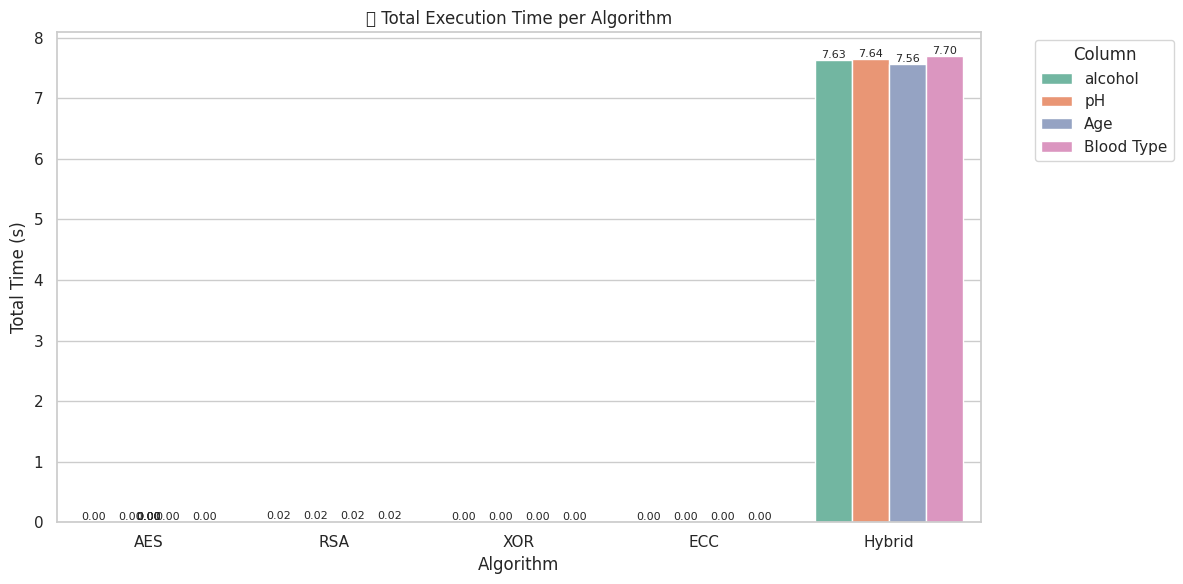

<ipython-input-29-e4d590cdfc7a>:76: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


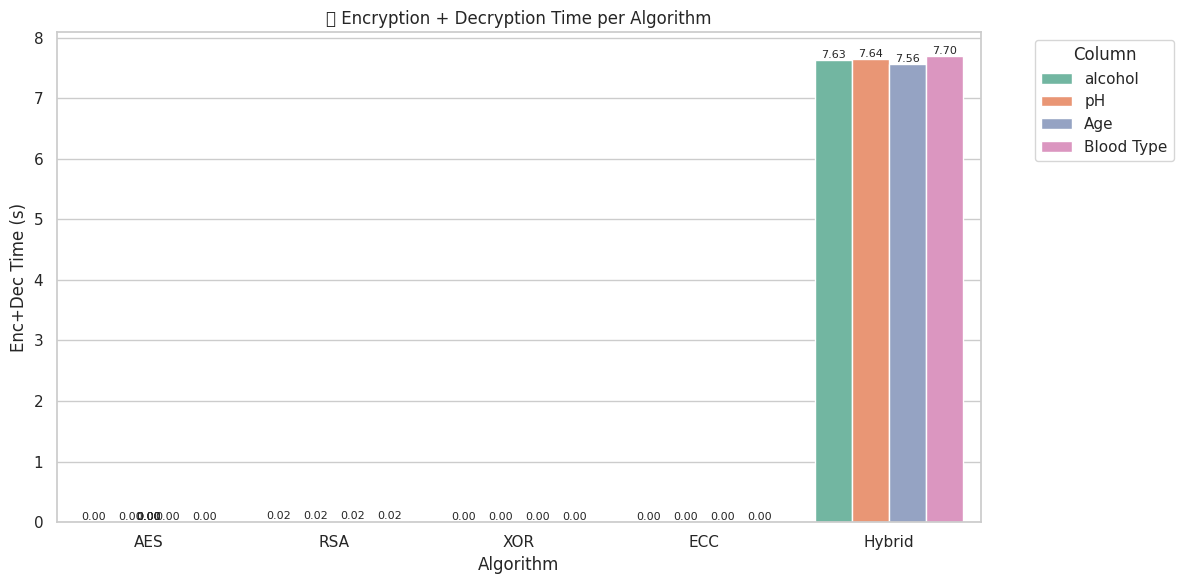

<ipython-input-29-e4d590cdfc7a>:76: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


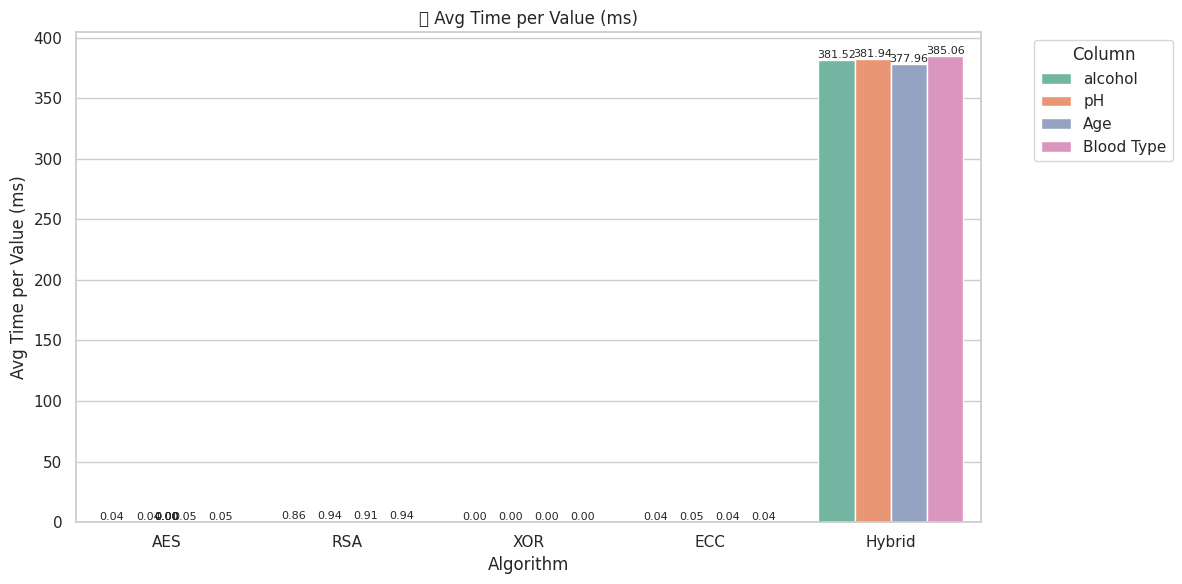

<ipython-input-29-e4d590cdfc7a>:76: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


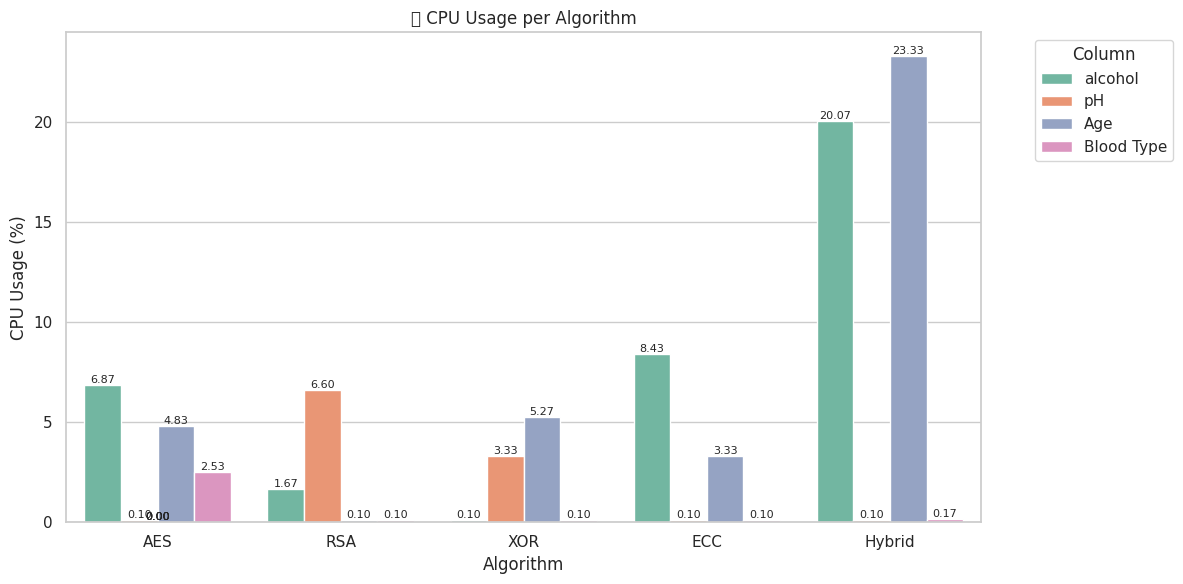

<ipython-input-29-e4d590cdfc7a>:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


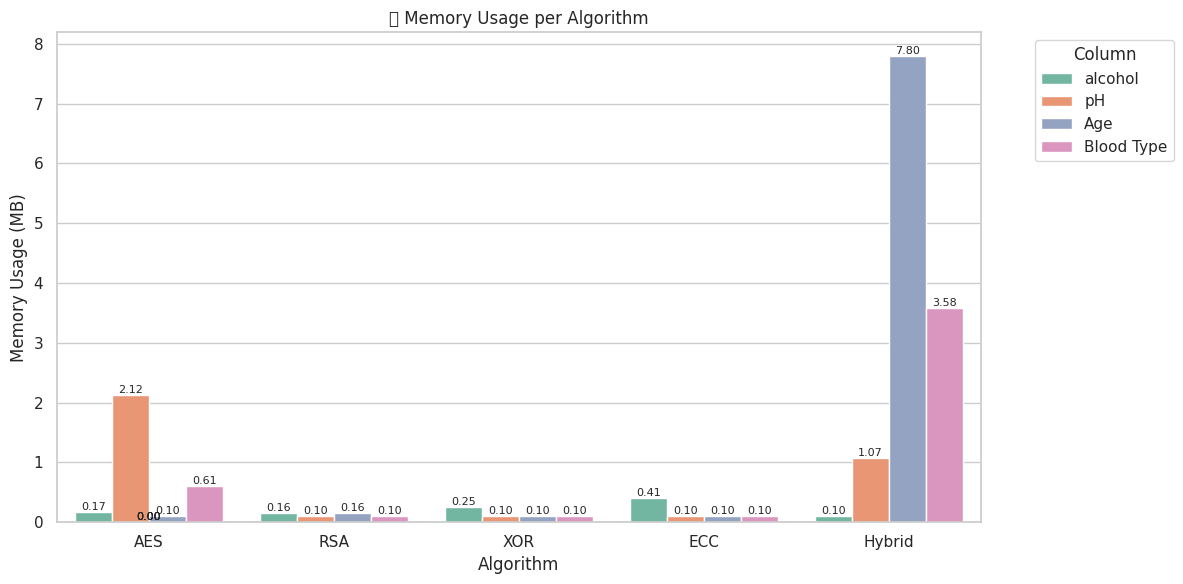

🏆 Best Algorithm for Wine Dataset:
Algorithm: XOR
Total Time (s): 0.0011
Avg Time per Value (ms): 0.0
CPU Usage (%): 0.1
Memory Usage (MB): 0.25


🏆 Best Algorithm for Health Dataset:
Algorithm: XOR
Total Time (s): 0.0011
Avg Time per Value (ms): 0.0
CPU Usage (%): 5.27
Memory Usage (MB): 0.1




In [29]:
# ==================== MAIN EXECUTION ====================

def run_benchmarks():
    """Run all benchmarks and generate visualizations"""
    # Load datasets
    wine_df, health_df = load_datasets()
    # print(wine_df.head(20))
    # health_df.head
    # Define columns to test
    columns_to_test = {
        'wine': ['alcohol', 'pH'],
        'health': ['Age', 'Blood Type']  # Removed 'Name' for brevity
    }

    # Run benchmarks
    results = []

    # Benchmark each algorithm on each column
    for col in columns_to_test['wine']:
        results.append(benchmark_algorithm("AES", wine_df, col, benchmark_aes))
        results.append(benchmark_algorithm("RSA", wine_df, col, benchmark_rsa))
        results.append(benchmark_algorithm("XOR", wine_df, col, benchmark_xor))
        results.append(benchmark_algorithm("ECC", wine_df, col, benchmark_ecc))
        results.append(benchmark_algorithm("Hybrid", wine_df, col, benchmark_hybrid))

    for col in columns_to_test['health']:
        results.append(benchmark_algorithm("AES", health_df, col, benchmark_aes))
        results.append(benchmark_algorithm("RSA", health_df, col, benchmark_rsa))
        results.append(benchmark_algorithm("XOR", health_df, col, benchmark_xor))
        results.append(benchmark_algorithm("ECC", health_df, col, benchmark_ecc))
        results.append(benchmark_algorithm("Hybrid", health_df, col, benchmark_hybrid))

    # Create and show DataFrame
    benchmark_df = pd.DataFrame(results)
    print("\n📈 Final Benchmark Results:")
    print(benchmark_df)

    # Add dataset column for visualization
    benchmark_df['Dataset'] = benchmark_df['Column'].apply(
        lambda col: 'Wine' if col in columns_to_test['wine'] else 'Health'
    )

    # Set seaborn style for plotting
    sns.set(style="whitegrid")

    # Generate visualizations
    plot_comparison(benchmark_df, "Total Time (s)", "🔁 Total Execution Time per Algorithm")
    plot_comparison(benchmark_df, "Enc+Dec Time (s)", "🔐 Encryption + Decryption Time per Algorithm")
    plot_comparison(benchmark_df, "Avg Time per Value (ms)", "⏱️ Avg Time per Value (ms)")
    plot_comparison(benchmark_df, "CPU Usage (%)", "🧠 CPU Usage per Algorithm")
    plot_comparison(benchmark_df, "Memory Usage (MB)", "📊 Memory Usage per Algorithm")

    # Find best algorithm for each dataset
    best_algorithm_for_dataset(benchmark_df, "Wine")
    best_algorithm_for_dataset(benchmark_df, "Health")

    return benchmark_df

def plot_comparison(df, metric, title):
    """Plot comparison bar charts"""
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x="Algorithm", y=metric, hue="Column", data=df,
        palette="Set2"
    )
    plt.title(title)
    plt.xlabel("Algorithm")
    plt.ylabel(metric)
    plt.legend(title="Column", bbox_to_anchor=(1.05, 1), loc='upper left')
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=8
        )
    plt.tight_layout()
    plt.show()

def best_algorithm_for_dataset(df, dataset_name):
    """Determine the best algorithm for a given dataset"""
    # Filter the dataset by dataset name (Wine or Health)
    dataset_results = df[df['Dataset'] == dataset_name]

    # Find the algorithm with the minimum total time
    best_algorithm = dataset_results.loc[dataset_results['Total Time (s)'].idxmin()]

    print(f"🏆 Best Algorithm for {dataset_name} Dataset:")
    print(f"Algorithm: {best_algorithm['Algorithm']}")
    print(f"Total Time (s): {best_algorithm['Total Time (s)']}")
    print(f"Avg Time per Value (ms): {best_algorithm['Avg Time per Value (ms)']}")
    print(f"CPU Usage (%): {best_algorithm['CPU Usage (%)']}")
    print(f"Memory Usage (MB): {best_algorithm['Memory Usage (MB)']}")
    print("\n")

    return best_algorithm

# Run all benchmarks
results_df = run_benchmarks()

In [ ]:
# ---------------------------------------------------------## ##------------------------------------------------------------------------------#